In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
from matplotlib import pyplot as pltp
import tensorflow as tf
import glob
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix

In [2]:
#Función que separa los parametros t,g,v del fileName
def separateParams(fileName):
    t = fileName.split("t")[1].split("g")[0]
    rest_of = fileName.split("t")[1].split("g")[1].split("v")
    g, v = rest_of
    return float(t), float(g)/10, float(v)

In [3]:
#Se definen los sets de training, test y validación
def train_val_test_split(X, y, train_size, val_size, test_size, random_state = 1):
    if train_size + val_size + test_size != 1.0:
        print("Incorrect sizes!")
        return None 
    X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size = test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size = val_size/(test_size + train_size), random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
files = glob.glob('../data-lineas-espectrales/filtered_wv_models/*')
file_qty = len(files)
print("Files qty: {}".format(file_qty))

Files qty: 5425


In [5]:
y = np.zeros((file_qty,3))
df = pd.read_csv(files[0], sep=" ", header=None)
n_points , n_columns = df.shape
print("points: {} | columns: {} ".format(n_points, n_columns))

points: 201 | columns: 2 


In [6]:
#Matriz que contiene las lineas espectrales
X = np.zeros((file_qty, n_points))
#Matriz que contiene los labels de cada linea espectral
y = np.zeros((file_qty, 3))

print(X.shape)
print(y.shape)

(5425, 201)
(5425, 3)


In [7]:
#extract files, se almacenan las lineas espectrales y labels en X e y respectivamente
for i, name in enumerate(files):
    file_name = name.split("/")[-1].split(".")[0].split("_")[1]
    df = pd.read_csv(name, sep=" ", header=None)
    t, g, v = separateParams(file_name)
    #Se almacena la línea espectral
    X[i, :] = df[1].values
    #Se almacena el label de la linea espectral
    y[i] = t, g, v

In [8]:
print(y[:4])

[[3.5e+04 2.0e+00 2.8e+02]
 [2.0e+04 2.0e+00 2.6e+02]
 [2.8e+04 2.0e+00 3.5e+02]
 [1.7e+04 3.0e+00 1.7e+02]]


In [9]:
#se normaliza y
standardScaler = StandardScaler()
standardScaler.fit(y)
normalized_y = standardScaler.transform(y)

In [10]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, normalized_y, .8, .1, .1)

In [11]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(4339, 201) (4339, 3)
(543, 201) (543, 3)
(543, 201) (543, 3)


In [12]:
time_steps = X.shape[1]
input_dimension = 1
print(time_steps)

201


In [13]:
sample_size = X_train.shape[0]
X_train_reshaped = X_train.reshape((sample_size, time_steps, input_dimension))
sample_size = X_val.shape[0]
X_val_reshaped = X_val.reshape((sample_size, time_steps, input_dimension))
sample_size = X_test.shape[0]
X_test_reshaped = X_test.reshape((sample_size, time_steps, input_dimension))
print("reshaped X_train: {}".format(X_train_reshaped.shape))
print("reshaped X_val: {}".format(X_val_reshaped.shape))
print("reshaped X_test: {}".format(X_test_reshaped.shape))

reshaped X_train: (4339, 201, 1)
reshaped X_val: (543, 201, 1)
reshaped X_test: (543, 201, 1)


In [77]:
#Arquitectura de la red
def build_conv1D_model():
    n_timesteps = X_train_reshaped.shape[1] #210
    n_features  = X_train_reshaped.shape[2] #1 
    model = tf.keras.Sequential(name="model_conv1D")
    model.add(tf.keras.layers.Input(shape=(n_timesteps,n_features)))
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='elu'))
    #model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', name="Conv1D_0"))
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=7, activation='softmax', name="Conv1D_1"))
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='selu', name="Conv1D_2"))
    model.add(tf.keras.layers.Conv1D(filters=8, kernel_size=3, activation='sigmoid', name="Conv1D_3"))
    tf.keras.layers.BatchNormalization()
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128,activation='elu', name="Dense_00"))
    model.add(tf.keras.layers.Dense(64,activation='relu', name="Dense_0"))
    model.add(tf.keras.layers.Dense(32, activation= "selu", name="Dense_1"))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.add(tf.keras.layers.Dense(3, activation = "linear", name="Dense_4"))
    


    optimizer = tf.keras.optimizers.RMSprop(0.001)

    l = tf.keras.losses.LogCosh()
    
    
    model.compile(loss='mse',optimizer=optimizer,metrics=['mse', 'accuracy'])
    return model

model_conv1D = build_conv1D_model()
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 199, 64)           256       
                                                                 
 Conv1D_1 (Conv1D)           (None, 193, 32)           14368     
                                                                 
 Conv1D_2 (Conv1D)           (None, 191, 16)           1552      
                                                                 
 Conv1D_3 (Conv1D)           (None, 189, 8)            392       
                                                                 
 flatten_5 (Flatten)         (None, 1512)              0         
                                                                 
 Dense_00 (Dense)            (None, 128)               193664    
                                                                 
 Dense_0 (Dense)             (None, 64)               

In [78]:
#train
epoch_qty = 80
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                patience=5)
history = model_conv1D.fit(X_train_reshaped, y_train, epochs=epoch_qty,
                    validation_data = (X_val_reshaped, y_val), 
                           verbose=1, callbacks=[callback])

Epoch 1/80
136/136 [==============================] - 4s 22ms/step - loss: 1.0248 - mse: 1.0248 - accuracy: 0.3390 - val_loss: 1.0021 - val_mse: 1.0021 - val_accuracy: 0.3039
Epoch 2/80
136/136 [==============================] - 3s 21ms/step - loss: 1.0093 - mse: 1.0093 - accuracy: 0.3395 - val_loss: 0.9769 - val_mse: 0.9769 - val_accuracy: 0.3039
Epoch 3/80
136/136 [==============================] - 3s 25ms/step - loss: 1.0052 - mse: 1.0052 - accuracy: 0.3489 - val_loss: 0.9629 - val_mse: 0.9629 - val_accuracy: 0.3370
Epoch 4/80
136/136 [==============================] - 3s 21ms/step - loss: 0.7844 - mse: 0.7844 - accuracy: 0.6117 - val_loss: 0.6629 - val_mse: 0.6629 - val_accuracy: 0.6519
Epoch 5/80
136/136 [==============================] - 3s 20ms/step - loss: 0.6245 - mse: 0.6245 - accuracy: 0.7172 - val_loss: 0.6049 - val_mse: 0.6049 - val_accuracy: 0.6611
Epoch 6/80
136/136 [==============================] - 3s 20ms/step - loss: 0.5550 - mse: 0.5550 - accuracy: 0.7495 - val_loss

136/136 [==============================] - 3s 21ms/step - loss: 0.1210 - mse: 0.1210 - accuracy: 0.8919 - val_loss: 0.1299 - val_mse: 0.1299 - val_accuracy: 0.9042
Epoch 48/80
136/136 [==============================] - 3s 21ms/step - loss: 0.1225 - mse: 0.1225 - accuracy: 0.8970 - val_loss: 0.1424 - val_mse: 0.1424 - val_accuracy: 0.8895
Epoch 49/80
136/136 [==============================] - 3s 19ms/step - loss: 0.1206 - mse: 0.1206 - accuracy: 0.8963 - val_loss: 0.0918 - val_mse: 0.0918 - val_accuracy: 0.9227
Epoch 50/80
136/136 [==============================] - 3s 19ms/step - loss: 0.1165 - mse: 0.1165 - accuracy: 0.8914 - val_loss: 0.1405 - val_mse: 0.1405 - val_accuracy: 0.9042
Epoch 51/80
136/136 [==============================] - 3s 20ms/step - loss: 0.1159 - mse: 0.1159 - accuracy: 0.8972 - val_loss: 0.0838 - val_mse: 0.0838 - val_accuracy: 0.9208
Epoch 52/80
136/136 [==============================] - 3s 20ms/step - loss: 0.1114 - mse: 0.1114 - accuracy: 0.8928 - val_loss: 0.11

Testing set Mean Abs Error:   66.30


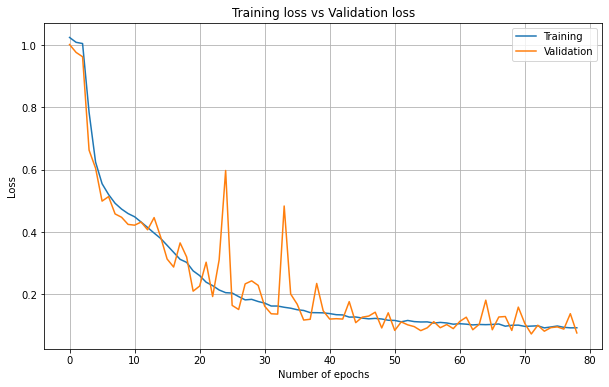

In [79]:
[loss, mae, accuracy] = model_conv1D.evaluate(X_test_reshaped, y_test, verbose=0)
print("Testing set Mean Abs Error: {:7.2f}".format(mae * 1000))

pred =model_conv1D.predict(X_test_reshaped)

y_pred_inv = standardScaler.inverse_transform(y)


train_loss = history.history['loss']


val_loss = history.history['val_loss']


def plot_train_val(A, B, n, xlabel, ylabel, title):
    pltp.figure(1, figsize=(10, 6))
    pltp.plot(range(n),A)
    pltp.plot(range(n),B)
    pltp.ylabel(xlabel)
    pltp.xlabel(ylabel)
    pltp.title(title)
    pltp.grid(True)
    pltp.legend(['Training', 'Validation'])
    pltp.show()


plot_train_val(train_loss, val_loss, 79, 'Loss', 'Number of epochs', 'Training loss vs Validation loss')

In [80]:
model_conv1D.save('../abs_error_66_3.h5')

In [81]:
#read besos
df = pd.read_csv("../data-lineas-espectrales/BESOS/2_Be_stars/HD37041/hd37041_2014-01-29_03-58-58_final_corr.txt", sep="\t", header=None)

m1 = df[0] >= 4460
m2 = df[0] <= 4480

df2 = df[m1][m2]

df2

/var/folders/w9/gh780vs52dgb_ypr6vd5g_4m0000gn/T/ipykernel_1020/942857022.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df[m1][m2]


,0,1
2367,4460.022618,0.979893
2368,4460.111978,0.998823
2369,4460.201338,1.020981
2370,4460.290697,1.021009
2371,4460.380057,1.018809
...,...,...
2586,4479.592386,0.986350
2587,4479.681746,0.977661
2588,4479.771106,0.998069
2589,4479.860465,0.996876


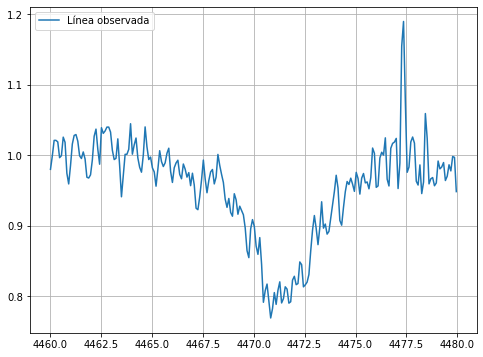

In [82]:
pltp.figure(figsize=(8,6))
pltp.plot(df2[0], df2[1], label="Línea observada")
#plt.plot(df4[0], df4[1], label="Modelo")
pltp.grid()
pltp.legend(loc="best")
pltp.show()

In [83]:
n = 201  # for 2 random indices
index = np.random.choice(df2[0].shape[0], n, replace=False) 
index.sort()

In [84]:
obs_waves = df2[0].values[index]

obs_flux = df2[1].values[index]
obs_flux.shape

(201,)

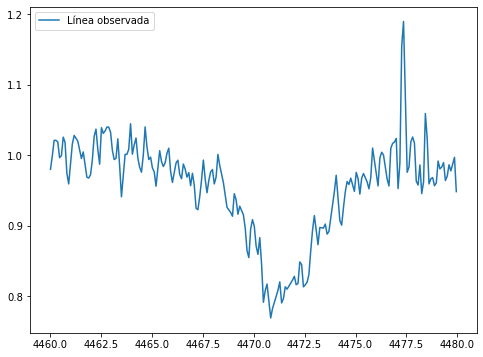

In [85]:
pltp.figure(figsize=(8,6))
pltp.plot(obs_waves, obs_flux ,label="Línea observada")
pltp.legend(loc="best")
pltp.show()

In [86]:
time_steps = 201
input_dimension = 1
obs_flux_reshaped = obs_flux.reshape((1, time_steps, input_dimension))

In [87]:
new_model = tf.keras.models.load_model('../abs_error_66_3.h5')

In [88]:
pred_obs = new_model.predict(obs_flux_reshaped)

In [89]:
print("t_eff:", pred_obs[0][0])
print("log g:", pred_obs[0][1])
print("v_rot:", pred_obs[0][2])

t_eff: -1.5863523
log g: 1.0382283
v_rot: -0.75742704


In [90]:
pred_obs_inv = standardScaler.inverse_transform(pred_obs)
print(pred_obs_inv[0,0])
print(pred_obs_inv[0,1])
print(pred_obs_inv[0,2])

15560.65
4.538228
182.25366
